In [1]:
from QUANTUM_PACKER import QUANTUM_PACKER
from qiskit import Aer
from qiskit import IBMQ
from PACKING_PROBLEM_DATA_LOADER import PACKING_PROBLEM_DATA_LOADER

Import a packing problem instance. Choose from one of the following ones:
"PUZZLE1", "PUZZLE2", "PUZZLE3", "SHAPES1", "SHAPES2", "SHIRTS", "TROUSERS", "SWIM". The variable pieces defines the list of polygons to pack. Each polygon is represented by a list of vertex coordinates $(x,y)$. The pieces must fit inside a rectangular container with fixed height, specified by the variable $H$. The strip packing problem consists in fitting all the pieces inside the container, avoiding overlap between the pieces and minimizing the container length $L$ needed, thereby minimizing the surface of material needed to produce the pieces.

In [2]:
problem_instance = "PUZZLE3"
packing_problem_data = PACKING_PROBLEM_DATA_LOADER(problem_instance)
pieces = packing_problem_data.pieces
H = packing_problem_data.height

Define a quantum backend for executing QAOA circuits. Leave the fields API_TOKEN_DE and API_URL_DE blank if you do not have access to the IBM Quantum System One located in Ehningen, Germany. If you have access to another backend, you can use it by adapting the code specifying the provider and backend's name. By default, the following code will use the qasm simulator and run it on your PC.

In [3]:
API_TOKEN_DE = ''
API_URL_DE = ''
if API_TOKEN_DE == '' and API_URL_DE == '':
    solver_backend = Aer.get_backend('qasm_simulator')
else:
    IBMQ.enable_account(API_TOKEN_DE, API_URL_DE)
    provider = IBMQ.get_provider(hub='fraunhofer-de', group='fhg-all')
    solver_backend = provider.get_backend('ibmq_ehningen')

Define a quantum simulator for optimizing the QAOA parameter vectors $\beta$ and $\gamma$ and specify the number of qubits available.

In [4]:
num_qubits = 16
backend = Aer.get_backend('qasm_simulator')

Create an instance of the QUANTUM_PACKER class for solving the packing problem. Choose the number of angles of rotations allowed for the pieces, e.g. 0, 2 (0 and 180 degrees), 4 (multiples of 90 degrees), 8 (multiples of 45 degrees) or 16. Specify the number of partitions used to create random groups of geometrically compatible pieces, e.g. 50. The variable tsp_solver represents the algorithm used to solve the Traveling Salesman Problem (TSP). This can be 'BF' (brute force), 'QAOA' (Quantum Approximate Optimization Algorithm) or 'QAOA+' (Quantum Alternating Operator Ansatz). The maximum cluster size is fixed to $4$ for QAOA and QAOA+, which means that we cannot solve TSP instances with more than 4 cities. If you wish to use brute force to solve TSPs, you may increase the max_cluster_size up to $10$ cities.

In [5]:
n_rotations = 8
n_partitions = 50
tsp_solver = 'QAOA'
distance_threshold = 0.1
max_cluster_size = 4
quantum_packer = QUANTUM_PACKER(problem_instance, H, pieces, n_rotations,
                                tsp_solver, distance_threshold, max_cluster_size, n_partitions,
                                num_qubits, backend, solver_backend)

Show the set of pieces to pack.

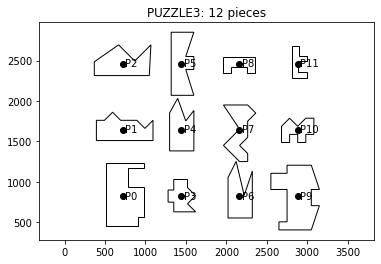

In [6]:
quantum_packer.show_pieces()

Solve the packing problem and show the best layout found.

The distance matrix and nofit functions have already been pre-computed and will be directly loaded
[[110332.9  99391.3 104405.9  88739.6  95897.1  89548.9 105074.1 141070.4
   65864.4  49802.6  69743.3  79106.9]
 [ 99391.3  27301.8  75994.1  50006.6  69341.8  63188.8  84261.1  51924.6
   46509.3 127987.4  69289.5  47487.5]
 [104405.9  75994.1  41237.7  50557.5  67522.6  83519.1  90059.7  40373.4
   49663.4 134586.9  47421.4  45566.4]
 [ 88739.6  50006.6  50557.5  47631.1  56754.8  79854.5  73505.2  82376.9
   23610.4 103540.   28144.   40057.7]
 [ 95897.1  69341.8  67522.6  56754.8  27838.9  60134.2  44784.5  86602.9
   53706.2 102904.4  53073.4  47315.1]
 [ 89548.9  63188.8  83519.1  79854.5  60134.2  62295.9  75743.3 125825.1
   50989.5  89455.6  70637.4  67416.2]
 [105074.1  84261.1  90059.7  73505.2  44784.5  75743.3  30438.6 114271.5
   70000.3 128547.   69936.9  69327.5]
 [141070.4  51924.6  40373.4  82376.9  86602.9 125825.1 114271.5 104631.4
   82237.3 172385.2  84117.9  84160.

C:\Users\pam\PycharmProjects\QuantumPacker\QUANTUM_PACKER.py:787: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  layout += list(packed_pieces)
C:\Users\pam\PycharmProjects\QuantumPacker\QUANTUM_PACKER.py:787: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  layout += list(packed_pieces)


            running local optimization...
            the optimized layout fits the container height
IMPROVED CONTAINER LENGTH: 1931.0
{'0-5-9': (0, 0, 800, 1088, 0), '1-2-4-7': (800, 0, 701, 1033, 0), '3-8-10-11': (1501, 0, 402, 756, 0), '6': (1501, 756, 700, 300, 0)}
        packing rectangles in strip of height H=1320.0
RectPack: Required height = 1088, required length = 2201
            found a layout that fits in that bin
            running local optimization...
            the optimized layout fits the container height
            the container length has not been improved
        packing rectangles in strip of height H=1440.0
RectPack: Required height = 1435, required length = 1556
            found a layout that fits in that bin
            running local optimization...
        packing rectangles in strip of height H=1200.0
        packing rectangles in strip of height H=1320.0
        packing rectangles in strip of height H=1440.0
RectPack: Required height = 1403, required le

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

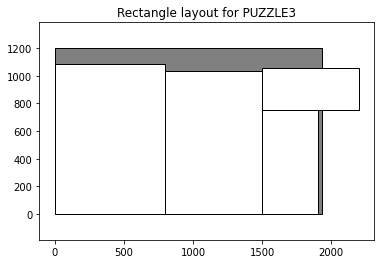

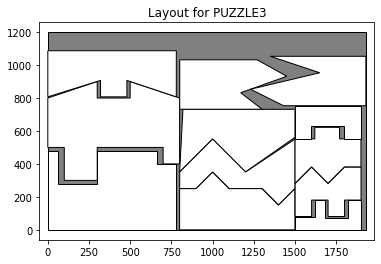

In [7]:
# solve the irregular packing problem
layout, L_min, partition_name, rectangle_layout = quantum_packer.solve()

# show the solution
if layout == None:
    print('WARNING: NO SOLUTION FOUND FOR IRREGULAR PACKING PROBLEM ' + problem_instance)
else:
    rectangle_layout_title = 'Rectangle layout for ' + problem_instance
    quantum_packer.show_layout(rectangle_layout, rectangle_layout_title, board_dimensions=(L_min, H))
    title = 'Layout for ' + problem_instance
    quantum_packer.show_layout(layout, title, board_dimensions=(L_min, H))